[ ] fit tempo di attivazione al variare della memoria.

[ ] parametri da fissare:n utenti, frazione di attivazione (30%??)

[x] acquisizione csv con i valori di attivazione e  memoria  (simulazioni a memoria fissa)

[ ] valore medio ed errore del tempo di attivazione per ogni memoria

[ ] fit con barre di errore 

In [10]:
library(data.table)
library(foreach)
library(doMC)

library(ggplot2)
library(plotrix)

library(ineq)
library(boot) 
library(reldist) # just for the gini() function
library(fBasics)

### Heading

In [49]:
int <- read.csv(file="../../log/state3/1-20m_1000u_20s_1000t/memoryLog2018_08_03_18_19_18.csv", nrows=11, sep=",", as.is=T)
maxtime    <- 1000
num_news   <- int$X..memorylog[6]
num_users  <- 1000
num_sources<- 20
memory  <- 6
#int

### Multicore detect

In [12]:
cores=detectCores()
#cluster <- makeCluster(cores[1] - 1)
registerDoMC(cores -1)
cores

[1] 8

In [13]:
HBp <- fread(file = '../../log/maggiora/HBp_news.csv', header=FALSE, sep=",")
nrow(HBp)

[1] 120

### Histograms

standar error functions

In [15]:
std <- function(x) sqrt(var(x)/length(x))
std1 <- function(x) sqrt(var(x)/(length(x)-1))

gini error with jacknife

In [17]:
## https://stats.stackexchange.com/questions/21868/gini-coefficient-and-error-bounds
calc.Gini.variance <- function(x) {
    N <- length(x)
    # using jacknifing as suggested by Tomson Ogwang - equation 7
    # in the Oxford Bulletin of Economics and Statistics, 62, 1 (2000)
    # ((n-1)/n) \times \sum_{k=1}^n (G(n,k)-\bar{G}(n))^2
    gini.bar <- Gini(x)
    gini.tmp <- vector(mode='numeric', length=N)
    for (k in 1:N) {
        gini.tmp[k] <- Gini(x[-k])
    }
    gini.bar <- mean(gini.tmp)
    sum((gini.tmp-gini.bar)^2)*(N-1)/N
    }
calc.Gini.variance(c(1,2,2,3,4,99)) 
Gini(c(1,2,2,3,4,99))


[1] 0.1696173

[1] 0.7462462

In [18]:
#https://stats.stackexchange.com/questions/21868/gini-coefficient-and-error-bounds
calc.Gini.bootstrap <- function(x, n, up, down) {
    y <- boot(data = x, statistic = gini, R = n, parallel="multicore", ncpus=(cores-1))
    qq <- quantile(y$t, probs=c(up, down))
    g <- gini(x)
    e1 <- g - as.numeric(qq[1])
    e2 <- as.numeric(qq[2]) - g
    s <- sd(y$t)
    return(c(g, e1, e2, s))
}

calc.Gini.bootstrap(c(1,2,2,3,4,99), 500, 0.25, 0.95)

[1] 0.74624625 0.04428211 0.02137352 0.03707827

In [19]:
bb <- 200
norm <- num_users/bb
num_sources*memory
threshold <- 1000

mean_news <- double()
mean_nerr <- double()
gini_news <- double()
gini_erru <- double()
gini_errd <- double()
gini_estd <- double()

for(i in 1:memory ){
    for(j in 1:num_sources){
        #foo <- data.frame(1:maxtime, as.vector(HBp[(i - 1)*num_sources + j,] - 1)/(num_users*norm))
        #p <- ggplot(foo, aes(1:maxtime, weight = as.vector(HBp[(i - 1)*num_sources + j,] - 1)/(num_users*norm))) + geom_histogram()
        #plot( p, col=rgb(0,0,1,1/4))#, xlim=c(0,10))  # first histogram
        
        #####  plot histogram #####
        #weighted.hist(
        #    1:maxtime ,as.vector(HBp[(i - 1)*num_sources + j,] - 1)/(num_users*norm), 
        #    col=rgb(0.05*i,0,1 - 0.05*(i-1),0.7),
        #    main=paste("Memory", as.character(i), "news", as.character(j)), 
        #    xlab="Time", ylab=paste("news", as.character(j)), breaks=bb)
        #box()
        ###########################

        temp_vector <- c(as.vector(HBp[(i - 1)*num_sources + j,] - 1, mode="numeric")/(num_users*norm))
        
        mean_news[(i - 1)*num_sources + j] <- mean(temp_vector[maxtime-threshold+1:maxtime])
        mean_nerr[(i - 1)*num_sources + j] <- std1(temp_vector[maxtime-threshold+1:maxtime])
    }
    to_gini <- mean_news[ ((i - 1) * num_sources + 1):( i * num_sources ) ]
    results <- calc.Gini.bootstrap(to_gini, 100000, 0.16, 0.84)
    gini_news[i] <- results[1]
    gini_errd[i] <- results[2]
    gini_erru[i] <- results[3]
    gini_estd[i] <- results[4]
}

[1] 400

ERROR: Error in quantile.default(y$t, probs = c(up, down)): missing values and NaN's not allowed if 'na.rm' is FALSE


In [48]:
normal <- function(x, mu, sig, scale, off) { off + scale * dnorm(x, mu, sig) }
sigmoid <- function(x, mu, sig, scale, off) { off + scale * 1/(sig + exp(mu*x)) }

chi2,pchi2
0.0007043929,0.9788263
0.0002673824,0.9869537
0.0002781867,0.9866928


chi2,pchi2
0.004847412,0.9444934
0.001992566,0.9643957
0.001980117,0.9645070


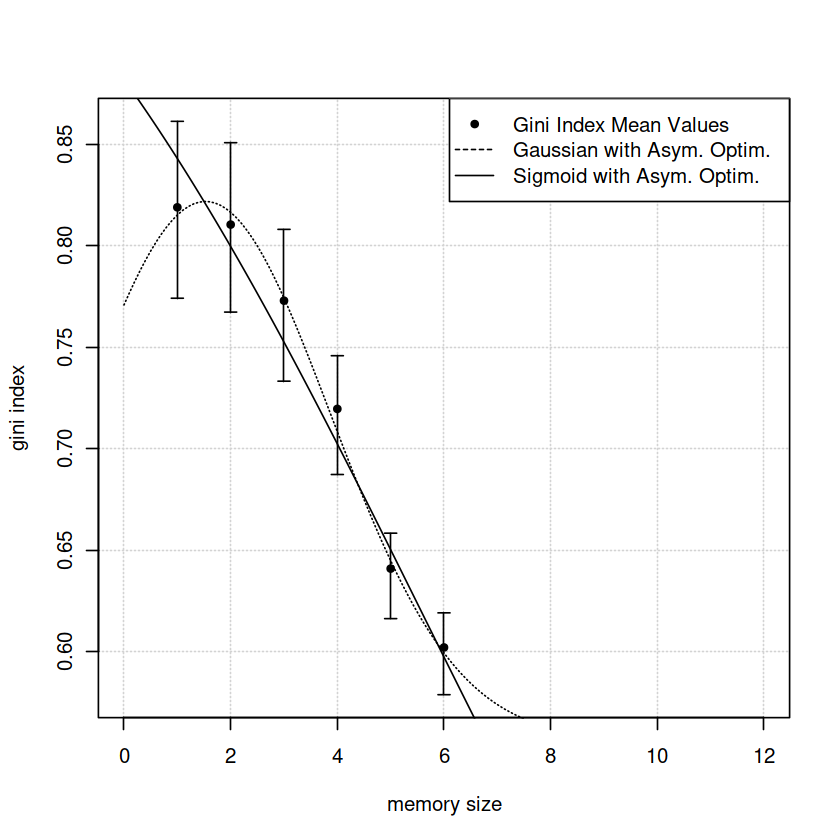

In [54]:
## https://stackoverflow.com/questions/15882323/r-robust-fitting-of-data-points-to-a-gaussian-function#15883835

fitGboot = function(x,y,w,mu,sig,scale,off){
    f = function(p){
        quant <- 0.16
        d = p[4] + p[3]*dnorm(x,mean=p[1],sd=p[2])
        sum( ( Heaviside(y, d)*quant + (1 - quant)*Heaviside(d, y) )* abs(y-d) )
    }
    optim(c(mu,sig,scale,off),f)
}

fitGstd = function(x,y,w,mu,sig,scale,off){
    f = function(p){
        d = p[4] + p[3]*dnorm(x,mean=p[1],sd=p[2])
        sum((d-y)^2/(w^2))
    }
    optim(c(mu,sig,scale,off),f)
}

fitGfunk = function(x,y,wu,wd,mu,sig,scale,off){
    f = function(p){
        d = p[4] + p[3]*dnorm(x,mean=p[1],sd=p[2])
        sum((d-y)^2/((2*wu)^2*Heaviside(d-y) + (2*wd)^2*Heaviside(y-d)))
    }
    optim(c(mu,sig,scale,off),f)
}


fitPstd  = fitGstd(Data$memory, Data$gini, Data$ginistd, 0.1,3.5,1.0,0.6)
pstd  = fitPstd$par

fitPboot = fitGboot(Data$memory, Data$gini, Data$giniup+Data$ginidown, pstd[1],pstd[2],pstd[3],pstd[4])
pboot = fitPboot$par

fitPfunk = fitGfunk(Data$memory, Data$gini, Data$giniup, Data$ginidown, 0.1,3.5,1.0,0.6)
pfunk = fitPfunk$par

DataChi <- data.frame(observed = Data$gini, 
                      expboot = normal(Data$memory, pboot[1], pboot[2], pboot[3], pboot[4]),
                      expstd  = normal(Data$memory, pstd[1], pstd[2], pstd[3], pstd[4]),
                      expfunk = normal(Data$memory, pfunk[1], pfunk[2], pfunk[3], pfunk[4]) )
chi2boot = sum(( DataChi$observed - DataChi$expboot)^2/ DataChi$expboot)
chi2std = sum(( DataChi$observed - DataChi$expstd)^2/ DataChi$expstd)
chi2funk = sum(( DataChi$observed - DataChi$expfunk)^2/ DataChi$expfunk)

data.frame(chi2=c(chi2boot, chi2std, chi2funk), pchi2=c(
    pchisq(chi2boot, df=1 , lower.tail=FALSE),
    pchisq(chi2std, df=1 , lower.tail=FALSE),
    pchisq(chi2funk, df=1 , lower.tail=FALSE)
))

## https://stackoverflow.com/questions/15882323/r-robust-fitting-of-data-points-to-a-gaussian-function#15883835

fitGboot = function(x,y,w,mu,sig,scale,off){
    f = function(p){
        quant <- 0.16
        d = p[4] + p[3]*(1/(p[2] + exp(p[1]*x)))
        sum( ( Heaviside(y, d)*quant + (1 - quant)*Heaviside(d, y) )* abs(y-d) )
    }
    optim(c(mu,sig,scale,off),f)
}

fitGstd = function(x,y,w,mu,sig,scale,off){
    f = function(p){
        d = p[4] + p[3]*(1/(p[2] + exp(p[1]*x)))
        sum((d-y)^2/(w^2))
    }
    optim(c(mu,sig,scale,off),f)
}

fitGfunk = function(x,y,wu,wd,mu,sig,scale,off){
    f = function(p){
        d = p[4] + p[3]*(1/(p[2] + exp(p[1]*x)))
        sum((d-y)^2/((2*wu)^2*Heaviside(d-y) + (2*wd)^2*Heaviside(y-d)))
    }
    optim(c(mu,sig,scale,off),f)
}

fitPstd  =  fitGstd(Data$memory, Data$gini, Data$ginistd, -0.1,3.5,1.0,0.6)
pstd  = fitPstd$par

fitPboot = fitGboot(Data$memory, Data$gini, Data$giniup+Data$ginidown, pstd[1],pstd[2],pstd[3],pstd[4])
pboot = fitPboot$par

fitPfunk = fitGfunk(Data$memory, Data$gini, Data$giniup, Data$ginidown, -0.1,3.5,1.0,0.6)
pfunk = fitPfunk$par

DataChi <- data.frame(observed = Data$gini, 
                      expboot = sigmoid(Data$memory, pboot[1], pboot[2], pboot[3], pboot[4]),
                      expstd  = sigmoid(Data$memory, pstd[1], pstd[2], pstd[3], pstd[4]),
                      expfunk = sigmoid(Data$memory, pfunk[1], pfunk[2], pfunk[3], pfunk[4]) )
chi2boot = sum(( DataChi$observed - DataChi$expboot)^2/ DataChi$expboot)
chi2std = sum(( DataChi$observed - DataChi$expstd)^2/ DataChi$expstd)
chi2funk = sum(( DataChi$observed - DataChi$expfunk)^2/ DataChi$expfunk)

data.frame(chi2=c(chi2boot, chi2std, chi2funk), pchi2=c(
    pchisq(chi2boot, df=1 , lower.tail=FALSE),
    pchisq(chi2std, df=1 , lower.tail=FALSE),
    pchisq(chi2funk, df=1 , lower.tail=FALSE)
))

plot(Data$memory, Data$gini, xlab="memory size", ylab="gini index", pch=20, xlim=range(0,12),ylim=range(c(Data$gini-Data$ginidown, Data$gini+Data$giniup)), panel.first=grid())
#arrows(Data$memory, Data$gini-Data$ginistd, Data$memory, Data$gini + Data$ginistd, length=0.05, angle=90, code=3, col='blue')
arrows(Data$memory, Data$gini-Data$ginidown, Data$memory, Data$gini + Data$giniup, length=0.05, angle=90, code=3)
par(new=TRUE)

#curve(sigmoid(x, pboot[1], pboot[2], pboot[3], pboot[4]), 0, 20 ,n=200, add=TRUE)
#curve(sigmoid(x, pstd[1], pstd[2], pstd[3], pstd[4]), 0, 20 ,n=200, add=TRUE, col='red')
curve(normal(x, gausspar[1], gausspar[2], gausspar[3], gausspar[4]), 0, 20 ,n=200, add=TRUE, col='black', lty=3)
curve(sigmoid(x, pfunk[1], pfunk[2], pfunk[3], pfunk[4]), 0, 20 ,n=200, add=TRUE, col='black')

legend("topright", pch = c(20, NA, NA), lty=c(NA,2, 1),
        col = c("black", "black", "black"), 
        legend = c("Gini Index Mean Values", "Gaussian with Asym. Optim.", "Sigmoid with Asym. Optim."))

[1] 0.0260438 0.0504198 0.0045844 0.1760992 0.0187056 0.0177322 0.0405616
 [8] 0.1698014 0.0097986 0.0252652 0.0376486 0.0053818 0.0147618 0.0070476
[15] 0.0083272 0.1815116 0.0049688 0.0043846 0.0099080 0.0552234

[1] 0.6033869

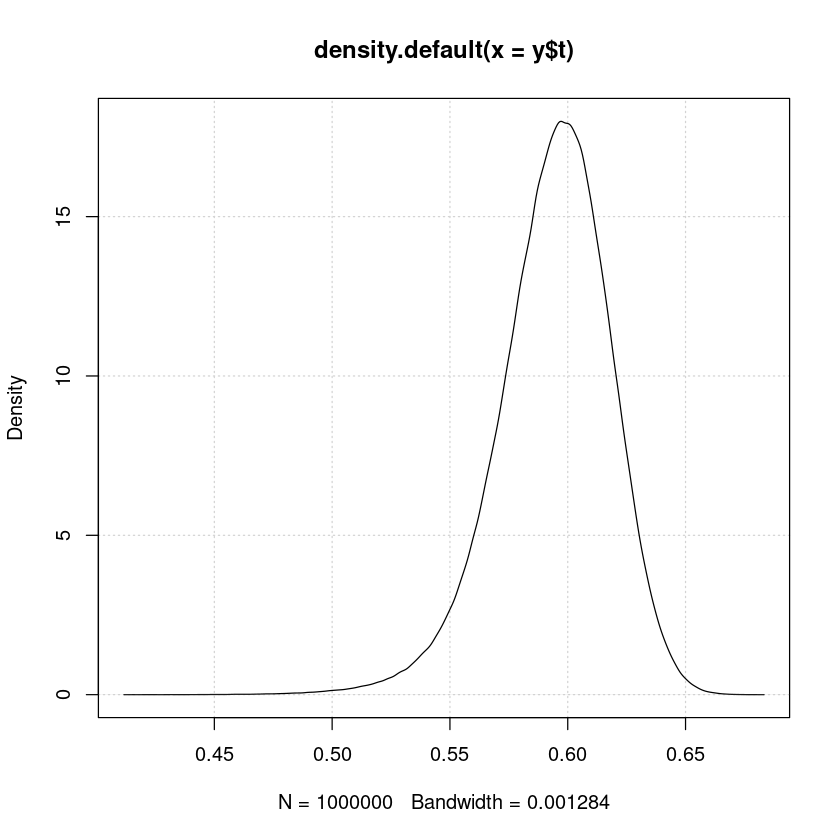

In [36]:
library(reldist) # just for the gini() function
library(boot) # for the boot() function
x <- mean_news[141:160]
mean_news[141:160]
gini(x)

#options(warn=-1)
y <- boot(data = x, statistic = gini, R = 1000000, parallel="multicore", ncpus=7)

#options(warn=0)

qq <- quantile(y$t, probs=c(0.025, 0.975))
plot(density(y$t), panel.first=grid())


In [37]:
quantile(y$t, probs=c(0.025, 0.975))

2.5%     97.5% 
0.5415678 0.6354075

In [38]:
sd(y$t)

[1] 0.02380465

In [39]:
a <- c(1, 2, 1)
a
x <- ifelse(a==1, 1, 2)
x
x <- ifelse(a==2, 1, 'a')
x


[1] 1 2 1

[1] 1 2 1

[1] "a" "1" "a"